In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [530]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces

from sklearn.preprocessing import LabelEncoder

In [531]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        my_buffer = []
        for i in range(batch_size):
            my_buffer.append(self.buffer[-batch_size+i])
        return my_buffer

    def __len__(self):
        return len(self.buffer)

In [532]:
import csv

menu_dict = {}
first = True
with open("./menu.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        if first:
          first=False
          continue
        idx, menu = row
        menu_dict[int(idx)] = menu
menu_dict

{0: '1명 닭꼬치',
 1: '간장치킨',
 2: '갈비탕',
 3: '강된장보리밥',
 4: '고구마치즈돈가스',
 5: '고구마피자',
 6: '고기',
 7: '고등어회',
 8: '곱창',
 9: '국밥',
 10: '김치볶음밥',
 11: '김치전',
 12: '김치찌개',
 13: '낙곱새',
 14: '냉면',
 15: '냉소바',
 16: '닭갈비',
 17: '닭강정',
 18: '닭꼬치',
 19: '닭똥집튀김',
 20: '닭발',
 21: '닭볶음탕',
 22: '닭우동',
 23: '대창',
 24: '덮밥',
 25: '돈가스',
 26: '돼지갈비',
 27: '돼지고기김치찜',
 28: '돼지국밥',
 29: '된장찌개',
 30: '두부김치',
 31: '떡볶이',
 32: '라면',
 33: '로제떡볶이',
 34: '로제마라샹궈',
 35: '마라떡볶이',
 36: '마라탕',
 37: '마제소바',
 38: '막국수',
 39: '멘보샤',
 40: '무뼈닭발',
 41: '바게트',
 42: '바나나 한개',
 43: '밥버거',
 44: '백반',
 45: '봉구스밥버거',
 46: '부대찌개',
 47: '분짜',
 48: '불고기백반',
 49: '불고기피자',
 50: '불닭게티',
 51: '비빔국수',
 52: '사케동',
 53: '삼각김밥',
 54: '삼겹살',
 55: '새우초밥',
 56: '샌드위치',
 57: '선지해장국',
 58: '설렁탕',
 59: '소고기덮밥',
 60: '소고기무국',
 61: '소곱창',
 62: '소바',
 63: '솥밥',
 64: '순대국',
 65: '순대국밥',
 66: '순두부찌개',
 67: '스테이크',
 68: '스파게티',
 69: '쌀국수',
 70: '씨리얼',
 71: '야끼소바',
 72: '양꼬치',
 73: '양념치킨',
 74: '양송이수프',
 75: '연어덮밥',
 76: '연어초밥',
 77: '연어회',
 78: '열무국수',
 7

In [534]:
# DQN 모델 정의 (이전에 정의한 것과 동일해야 함)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# 에이전트 정의 (이전에 정의한 것과 동일해야 함)
class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_buffer):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)
        self.epsilon = 0.1  # 사용자 입력에서는 낮은 탐색 확률 사용
        self.epsilon_min = 0.01

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        action = q_values.max(1)[1].item()
        
        return action, q_values

    def update_model(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)
        
        current_q_values = self.model(states).gather(1, actions.view(-1, 1)).squeeze(1)
        max_next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * 0.99 * max_next_q_values

        loss = nn.MSELoss()(current_q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# 모델 및 에이전트 초기화
state_dim = 6  # 상태 차원 (예시)
action_dim = len(menu_dict)  # 행동 차원 (예시, 메뉴 수)
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(state_dim, action_dim, replay_buffer)

# 체크포인트에서 모델 불러오기
checkpoint_path = './model/final_model_state_dict.pth'  # 예시 체크포인트 경로
checkpoint = torch.load(checkpoint_path)
agent.model.load_state_dict(checkpoint)
agent.model.eval()

DQN(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=116, bias=True)
)

In [535]:
def get_user_input():
    feeling = float(input("기분을 숫자로 입력하세요 (예: 1~10, 1: 최악, 10: 최고): "))
    weather = float(input("날씨를 숫자로 입력하세요 (예: 0: 맑음, 1: 구름, 2: 흐림, 3: 비, 4: 눈): "))
    temp = float(input("체감 온도를 숫자로 입력하세요 (예: 1~10, 1: 추움, 10: 더움): "))
    time = float(input("체감 식사 시간대를 입력하세요 (0: 아침, 1: 점심, 2: 저녁, 3: 야식): "))
    num_people = float(input("인원수를 숫자로 입력하세요 (예: 1, 2, 3, 4 or 5명 이상: 5): "))
    gender = float(input("성별을 입력하세요 (0: 남성, 1: 여성): "))
    state = [feeling, weather, temp, time, num_people, gender]
    return state

def get_user_feedback(action):
    recommended_menus = menu_dict[action]
    feedback = int(input(f"추천된 메뉴: {recommended_menus}. 만족하셨나요? (1: 예, 0: 아니오): "))
    return feedback

In [537]:
# 사용자 입력 받기
state = get_user_input()

# 모델을 통해 메뉴 추천 받기
action, q_value = agent.select_action(state)

# 사용자 피드백 받기
reward = get_user_feedback(action)
done = True  # 단일 스텝이므로 에피소드 종료

# 리플레이 버퍼에 경험 추가
next_state = state  # 단일 스텝이므로 상태가 변하지 않음
agent.replay_buffer.push(state, action, reward, next_state, done)

In [526]:
# 사용자 피드백을 바탕으로 모델 업데이트   아직 구현 안됨
batch_size = 1  # 단일 사용자 피드백이므로 배치 크기를 1로 설정
print(action)
agent.update_model(batch_size)

35
tensor([[-1.8534, -1.2835, -1.6721, -2.7721, -1.7791, -1.9205, -3.2602, -1.8648,
         -1.9829, -3.7335, -1.8329, -1.7251, -1.6378, -1.6758, -2.3379, -1.8201,
         -2.1955, -1.5408, -1.6900, -2.0315, -3.0437, -1.6749, -1.9298, -1.9248,
         -3.5639, -1.7553, -2.0900, -1.5469, -1.8242, -3.5551, -1.5788, -3.5775,
         -1.1987, -2.2391, -1.5868, -0.9070, -0.9225, -3.2100, -1.7657, -2.1878,
         -2.8535, -1.4991, -3.8671, -1.9753, -1.6077, -1.9772, -2.1619, -1.5199,
         -2.5573, -1.8917, -1.6972, -1.5690, -1.5787, -2.0799, -2.9908, -3.1854,
         -2.3221, -1.7814, -2.2092, -1.8530, -1.8201, -2.2212, -2.0924, -1.4364,
         -1.9176, -1.3367, -1.9609, -2.2384, -1.7060, -1.4190, -2.1038, -1.6288,
         -2.1032, -2.2093, -1.8031, -1.7425, -1.9774, -3.7320, -2.3913, -3.0951,
         -2.1710, -1.3734, -1.6701, -2.0771, -1.9599, -1.8365, -2.7730, -1.5031,
         -1.8744, -2.1101, -2.1113, -3.1574, -2.2599, -1.3822, -1.4564, -1.7674,
         -3.0818, -1.7062

In [538]:
torch.save(agent.model.state_dict(), './model/final_model_state_dict.pth')
torch.save(agent.model, './model/final_model.pth')

In [540]:
def softmax(x):
    # 입력 배열 x에 대해 softmax 연산 수행
    exp_x = np.exp(x - np.max(x))  # 입력 배열에서 최대값을 빼준 후 softmax 계산
    softmax_x = exp_x / np.sum(exp_x)  # softmax 계산
    return softmax_x

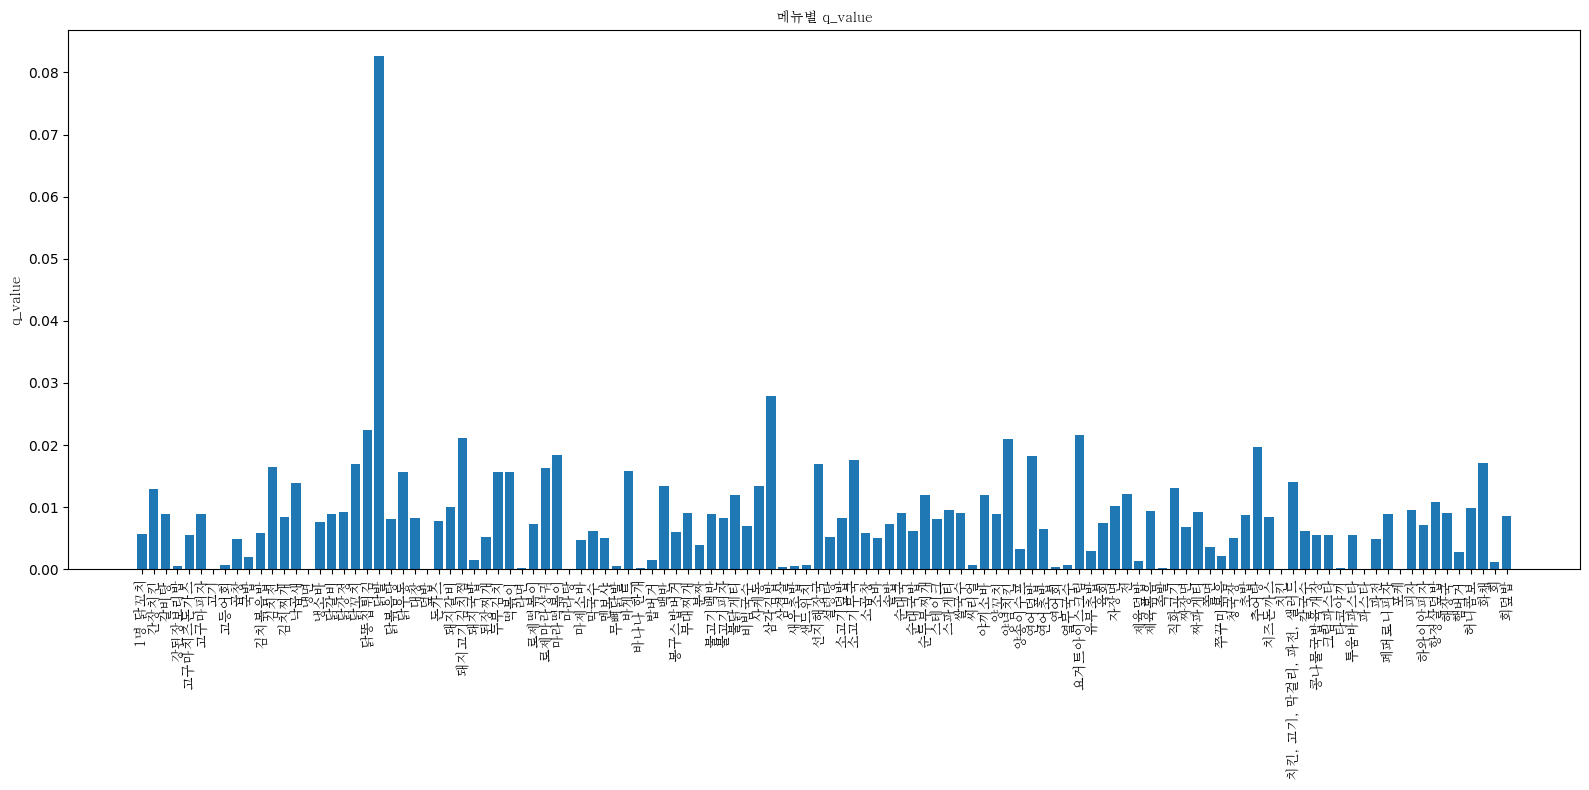

In [541]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 한글 폰트 설정
path = 'C:/Windows/Fonts/batang.ttc'  # 사용할 한글 폰트 파일 경로
fontprop = fm.FontProperties(fname=path)

# 그래프 그리기
plt.figure(figsize=(16, 8))
plt.bar(menu_dict.values(), softmax(q_value.numpy().flatten()))

# x축 레이블 폰트 설정
plt.xticks(rotation=90, ha='center', fontsize=10, fontproperties=fontprop)
plt.ylabel('q_value', fontproperties=fontprop)  # y축 레이블
plt.title('메뉴별 q_value', fontproperties=fontprop)  # 그래프 제목

plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()